In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from image_extractor import DataSetup
data = DataSetup()

OS: Windows
0 :  overall_geometry
1 :  overall_rgb
2 :  overall_hsv
3 :  color_grid
4 :  glcm_grid
5 :  comp_hsv
6 :  lbp_hist
7 :  haralick
8 :  red_haralick
9 :  blue_haralick


In [21]:
data.concat(dataID=[0, 1, 5, 7, 8, 9])
model_dir = 'D:./TF_backup/mlp/' + data.model_name
checkpoint_dir = 'D:./TF_checkpoint/mlp/weight/'
print(model_dir)

input_shape = (data.length,)
batch_size = 8

model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
)

x_test size: (1260, 253)
x_train size: (7140, 253)
y_test size: (1260, 14)
y_train size: (7140, 14)
Model name = ' overall_geometry_overall_rgb_comp_hsv_haralick_red_haralick_blue_haralick.h5 '
D:./TF_backup/mlp/overall_geometry_overall_rgb_comp_hsv_haralick_red_haralick_blue_haralick.h5


In [22]:
normalizer = layers.Normalization()
normalizer.adapt(data.x_train)

# Define model
input_layer = layers.Input(shape=input_shape)
norm = normalizer(input_layer)
den1 = layers.Dense(512, activation='tanh', kernel_initializer='HeNormal')(norm)
drop1 = layers.Dropout(0.2)(den1)
den2 = layers.Dense(512, activation='tanh', kernel_initializer='HeNormal')(drop1)
drop2 = layers.Dropout(0.2)(den2)
den3 = layers.Dense(512, activation='tanh', kernel_initializer='HeNormal')(drop2)
drop3 = layers.Dropout(0.2)(den3)
# den4 = layers.Dense(512, activation='tanh', kernel_initializer='HeNormal')(drop3)
# drop4 = layers.Dropout(0.2)(den4)
den5 = layers.Dense(14, activation='softmax')(drop3)
model = keras.Model(input_layer, den5)

opt = tf.keras.optimizers.SGD(
    learning_rate=0.00008,
    momentum=0.2,
    nesterov=True,
    name='SGD',
)

model.compile(
    optimizer=opt, 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
    )

# model = keras.models.load_model(model_dir)

In [23]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 253)]             0         
                                                                 
 normalization_3 (Normalizat  (None, 253)              507       
 ion)                                                            
                                                                 
 dense_12 (Dense)            (None, 512)               130048    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                           

In [24]:
epochs = 20
history = model.fit(data.x_train, data.y_train, batch_size=8, shuffle=True, epochs=epochs, callbacks=[model_checkpoint])
epochs = 20
history = model.fit(data.x_train, data.y_train, batch_size=4, shuffle=True, epochs=epochs, callbacks=[model_checkpoint])
model.save(model_dir)

Epoch 1/20
893/893 [==============================] - 5s 5ms/step - loss: 2.8806 - accuracy: 0.0950
Epoch 2/20
893/893 [==============================] - 4s 4ms/step - loss: 2.3496 - accuracy: 0.2244
Epoch 3/20
893/893 [==============================] - 4s 4ms/step - loss: 2.0594 - accuracy: 0.3158
Epoch 4/20
893/893 [==============================] - 4s 4ms/step - loss: 1.8501 - accuracy: 0.3730
Epoch 5/20
893/893 [==============================] - 4s 4ms/step - loss: 1.7112 - accuracy: 0.4228
Epoch 6/20
893/893 [==============================] - 4s 5ms/step - loss: 1.6262 - accuracy: 0.4485
Epoch 7/20
893/893 [==============================] - 3s 4ms/step - loss: 1.5474 - accuracy: 0.4752
Epoch 8/20
893/893 [==============================] - 4s 4ms/step - loss: 1.4809 - accuracy: 0.4882
Epoch 9/20
893/893 [==============================] - 4s 4ms/step - loss: 1.4198 - accuracy: 0.5155
Epoch 10/20
893/893 [==============================] - 4s 4ms/step - loss: 1.3793 - accuracy: 0.5234

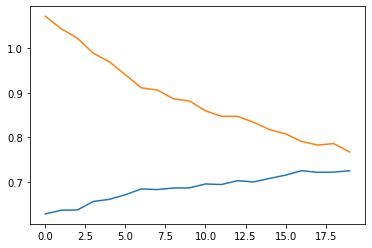

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

In [26]:
score = model.evaluate(data.x_test, data.y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

40/40 [==============================] - 0s 2ms/step - loss: 0.7133 - accuracy: 0.7437
Test loss: 0.7132627964019775
Test accuracy: 0.7436507940292358


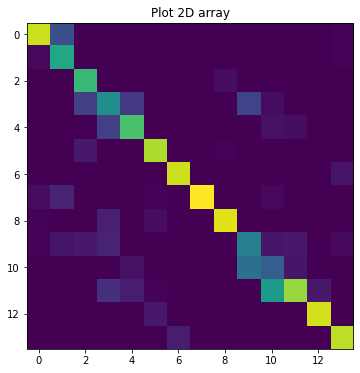

In [20]:
i = 0
cmatrix = np.zeros((14,14), dtype=np.int16)
bat = int(len(data.x_test)/60)
for i in range(0, len(data.x_test),bat):
    result = model.predict_on_batch(data.x_test[i:i+bat])
    ans = data.y_test[i:i+bat]
    for j in range(bat):
        id1 = np.argmax(result[j])
        id2 = np.argmax(ans[j])
        cmatrix[id1, id2] = cmatrix[id1][id2] + 1

cmatrix = np.absolute(cmatrix)
# print(repr(cmatrix))

fig = plt.figure(figsize=(6,6))
plt.imshow(cmatrix)
plt.title("Plot 2D array")
plt.show()

In [16]:
classes_name = ['Agglutinated', 'Brittle', 'Compartmentalized_Brown', 'Compartmentalized_PartiallyPurple', 'Compartmentalized_Purple', 'Compartmentalized_Slaty', 'Compartmentalized_White', 'Flattened', 'Moldered', 'Plated_Brown', 'Plated_PartiallyPurple', 'Plated_Purple', 'Plated_Slaty', 'Plated_White']
acc = []
for i in range(14):
    acc.append(np.round(cmatrix[i][i]/90,3))
    print(classes_name[i] + ': \t \t' + str(acc[i]))
print(np.mean(acc))

Agglutinated: 	 	0.911
Brittle: 	 	0.567
Compartmentalized_Brown: 	 	0.7
Compartmentalized_PartiallyPurple: 	 	0.5
Compartmentalized_Purple: 	 	0.633
Compartmentalized_Slaty: 	 	0.889
Compartmentalized_White: 	 	0.911
Flattened: 	 	1.0
Moldered: 	 	0.822
Plated_Brown: 	 	0.456
Plated_PartiallyPurple: 	 	0.267
Plated_Purple: 	 	0.833
Plated_Slaty: 	 	0.933
Plated_White: 	 	0.911
0.7380714285714286
